In [158]:
import dask.dataframe as dd
import os
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from sklearn.linear_model import LinearRegression, LogisticRegression

from hyperopt import hp, tpe
from hyperopt.fmin import fmin

from pandas_profiling import ProfileReport

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer, FunctionTransformer

from sklearn.model_selection import train_test_split

import lightgbm

from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold, TimeSeriesSplit, cross_val_score

from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import roc_auc_score

from feature_selector import FeatureSelector

from catboost import CatBoostClassifier

from sklearn.linear_model import ElasticNet
from sklearn.svm import SVC

from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score

%matplotlib inline

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(
                        np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(
                        np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(
                        np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(
                        np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(
                        np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(
                        np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(
        100 * (start_mem - end_mem) / start_mem))

    return df

In [3]:
def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True, sep=';')
    df = reduce_mem_usage(df)
    return df

In [2]:
def sortByDate(df, validateSet=False):
    df['SNAP_DATE'] = pd.to_datetime(df['SNAP_DATE'], format='%d.%m.%y')
    df['BASE_TYPE'] -= 1
    if validateSet:
        df = df.groupby(by="SK_ID", group_keys=False).apply(lambda grp: grp.nlargest(1, 'SNAP_DATE'))
    return df#.groupby(by="SK_ID", group_keys=False).apply(lambda grp: grp.nlargest(1, 'SNAP_DATE'))

In [5]:
df = import_data('condition_csi/dataset/bs_avg_kpi.csv')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\pandas\io\parsers.py", line 1848, in read
    data = self._reader.read(nrows)
  File "pandas/_libs/parsers.pyx", line 876, in pandas._libs.parsers.TextReader.read
  File "pandas/_libs/parsers.pyx", line 891, in pandas._libs.parsers.TextReader._read_low_memory
  File "pandas/_libs/parsers.pyx", line 968, in pandas._libs.parsers.TextReader._read_rows
  File "pandas/_libs/parsers.pyx", line 1094, in pandas._libs.parsers.TextReader._convert_column_data
  File "pandas/_libs/parsers.pyx", line 1134, in pandas._libs.parsers.TextReader._convert_tokens
  File "pandas/_libs/parsers.pyx", line 1180, in pandas._libs.parsers.TextReader._convert_with_dtype
  File "C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\pandas\core\dtypes\common.py", line 811, in is_integer_dtype
    def is_integer_dtype(arr_or_dtype):
KeyboardInterrupt

During h

TypeError: must be str, not list

In [61]:
subs_csi = pd.read_csv('train/subs_csi_train.csv', index_col='SK_ID')

subs_features = pd.read_csv('train/subs_features_train.csv', index_col='SK_ID')

subs_bs_consumption = pd.read_csv('train/subs_bs_consumption_train.csv')
#subs_bs_data_session_train = pd.read_csv('train/subs_bs_data_session_train.csv', index_col='SK_ID')
#subs_bs_voice_session_train = pd.read_csv('train/subs_bs_voice_session_train.csv', index_col='SK_ID')

In [62]:
df =subs_csi.merge(subs_features, on="SK_ID")

In [63]:
df = df.merge(subs_bs_consumption.groupby(by=["SK_ID", "MON"], as_index=False).sum().set_index('SK_ID'), on='SK_ID')

In [64]:
df = sortByDate(df)

In [65]:
df.head()

,CSI,CONTACT_DATE,SNAP_DATE,COM_CAT#1,COM_CAT#2,COM_CAT#3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT#7,...,COM_CAT#30,COM_CAT#31,COM_CAT#32,COM_CAT#33,COM_CAT#34,MON,CELL_LAC_ID,SUM_MINUTES,SUM_DATA_MB,SUM_DATA_MIN
SK_ID,,,,,,,,,,,,,,,,,,,,,
2,0,4.05,2002-03-01,7,77,10,0,1,10.0,2,...,0.002785,0.029765,0.027579,0.103896,NaN,1.03,18475468,0.060476,0.004970,0.364847
2,0,4.05,2002-03-01,7,77,10,0,1,10.0,2,...,0.002785,0.029765,0.027579,0.103896,NaN,1.04,16170315,0.046933,0.002767,0.344638
2,0,4.05,2002-03-01,7,77,10,0,1,10.0,2,...,0.002785,0.029765,0.027579,0.103896,NaN,1.05,16857495,0.036728,0.004374,0.383733
2,0,4.05,2002-02-01,7,77,9,0,1,10.0,2,...,0.001954,0.054871,0.027579,0.103896,NaN,1.03,18475468,0.060476,0.004970,0.364847
2,0,4.05,2002-02-01,7,77,9,0,1,10.0,2,...,0.001954,0.054871,0.027579,0.103896,NaN,1.04,16170315,0.046933,0.002767,0.344638


In [66]:
df=df[df['ACT']==1]

In [67]:
X, y = df.drop(columns=["CSI", "SNAP_DATE", "CONTACT_DATE", 'COM_CAT#24', 'ACT', 'MON', 'CELL_LAC_ID']), df["CSI"]

In [68]:
X.shape

(139555, 35)

In [11]:
profileReport = ProfileReport(df)
profileReport

Number of variables,43
Number of observations,139555
Total Missing (%),0.1%
Total size in memory,45.8 MiB
Average record size in memory,344.0 B
Numeric,34
Categorical,0
Boolean,4
Date,1
Text (Unique),0
Rejected,4


In [69]:
categorical_features = ['ARPU_GROUP','DEVICE_TYPE_ID', 'INTERNET_TYPE_ID'] #['ARPU_GROUP', 'COM_CAT#1', 'COM_CAT#2', 'COM_CAT#3', 'COM_CAT#7', 'COM_CAT#34', 'DEVICE_TYPE_ID', 'INTERNET_TYPE_ID']
binary_features = ['BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', "CSI"]
numerical_features = set(X.columns) - set(categorical_features) - set(binary_features)

In [86]:
X[categorical_features] = X[categorical_features].astype('int', errors='ignore')

numerical_features = list(numerical_features)

X[categorical_features] = X[categorical_features].astype('category', errors='ignore')

In [71]:
profileReport.description_set['variables']['type'] == 'BOOL'

ACT                 False
ARPU_GROUP          False
BASE_TYPE            True
CELL_LAC_ID         False
COM_CAT#1           False
COM_CAT#17          False
COM_CAT#18          False
COM_CAT#19          False
COM_CAT#2           False
COM_CAT#20          False
COM_CAT#21          False
COM_CAT#22          False
COM_CAT#23          False
COM_CAT#24          False
COM_CAT#25           True
COM_CAT#26           True
COM_CAT#27          False
COM_CAT#28          False
COM_CAT#29          False
COM_CAT#3           False
COM_CAT#30          False
COM_CAT#31          False
COM_CAT#32          False
COM_CAT#33          False
COM_CAT#34          False
COM_CAT#7           False
COM_CAT#8           False
CONTACT_DATE        False
COST                False
CSI                  True
DEVICE_TYPE_ID      False
INTERNET_TYPE_ID    False
ITC                 False
MON                 False
RENT_CHANNEL        False
REVENUE             False
ROAM                False
SK_ID               False
SNAP_DATE   

0 features with greater than 0.60 missing values.

0 features with a single unique value.

1 features with a correlation magnitude greater than 0.98.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.997304	valid_0's binary_logloss: 0.124166
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.997897	valid_0's binary_logloss: 0.124039
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.997615	valid_0's binary_logloss: 0.124573
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.997377	valid_0's binary_logloss: 0.127124
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration i

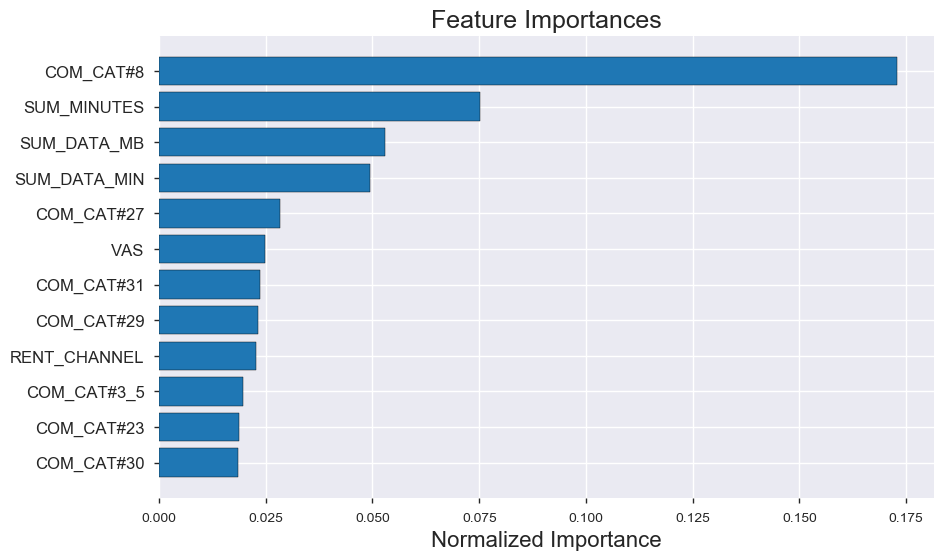

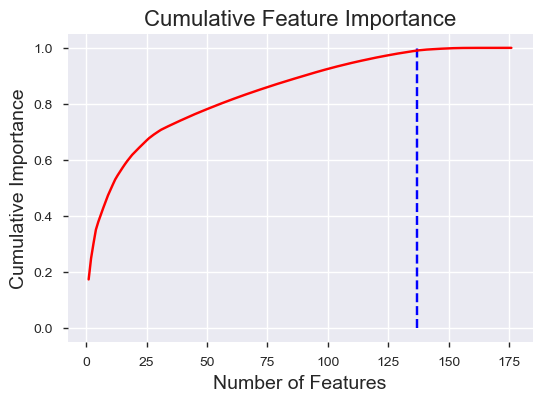

137 features required for 0.99 of cumulative importance


In [358]:
fs = FeatureSelector(data = X, labels = y)

fs.identify_all(selection_params = {'missing_threshold': 0.6, 'correlation_threshold': 0.98, 
                                    'task': 'classification', 'eval_metric': 'auc', 
                                     'cumulative_importance': 0.99})
fs.plot_feature_importances(threshold = 0.99, plot_n = 12)

In [359]:
train_removed_all_once = fs.remove(methods = 'all', keep_one_hot = False)

['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance'] methods have been run

Removed 154 features including one-hot features.


In [13]:
len(X.columns) - len(train_removed_all_once.columns)

NameError: name 'train_removed_all_once' is not defined

In [72]:
X = train_removed_all_once

NameError: name 'train_removed_all_once' is not defined

In [73]:
profileReport.get_rejected_variables()

['COM_CAT#22', 'COM_CAT#23', 'COM_CAT#28']

In [87]:
X = X.drop(columns=['COM_CAT#22','COM_CAT#23', 'COM_CAT#28'])

KeyError: "['COM_CAT#22' 'COM_CAT#23' 'COM_CAT#28'] not found in axis"

In [88]:
categorical_features = list(set(X).intersection(categorical_features))
numerical_features = list(set(X).intersection(numerical_features))
binary_features = list(set(X).intersection(binary_features))
categorical_indices = np.where(X.dtypes == 'category')

In [89]:
X[categorical_features].head()

,INTERNET_TYPE_ID,ARPU_GROUP,DEVICE_TYPE_ID
SK_ID,,,
2,2.0,10.0,5.0
2,2.0,10.0,5.0
2,2.0,10.0,5.0
2,2.0,10.0,5.0
2,2.0,10.0,5.0


In [90]:
X.shape

(139555, 32)

In [ ]:
len(categorical_indices[0]) == len(categorical_features)

In [91]:
classifier_pipeline = Pipeline(steps = [       
    ('feature_processing', ColumnTransformer(transformers = [        
            #binary
            ('binary', Pipeline([
                ('impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))]),
            binary_features), 
                    
            #numeric
            ('numeric', Pipeline([
                ('impute', SimpleImputer(missing_values=np.nan, strategy='mean')),
                ('scale', RobustScaler()),
                ('transform', QuantileTransformer(output_distribution='normal')),
                ('engineer', PolynomialFeatures())]),
            numerical_features),
        
            #categorical
            ('categorical', Pipeline([
                ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-10000)),
                ('toint', FunctionTransformer(lambda x: x.astype('int64')))
]),
             #                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
            categorical_features),
            
    ])),
    ]
)

CatBoostClassifier()

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [93]:
X_train = classifier_pipeline.fit_transform(X_train)
X_test = classifier_pipeline.fit_transform(X_test)

C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate

In [94]:
len(X_train[0,:])

384

In [95]:
catboost_classifier = CatBoostClassifier(iterations=4000, random_seed=666, 
                                        depth=4, learning_rate=0.2,
                                        use_best_model=True,
                                        best_model_min_trees=40,
                                        od_type="Iter",
                                        l2_leaf_reg=7,
                                        od_wait=500,
                                        loss_function='Logloss', eval_metric='AUC')

In [96]:
catboost_classifier.fit(X=X_train, y=y_train, plot=True, verbose=False, eval_set=(X_test, y_test), cat_features=np.arange(381, 384))

KeyboardInterrupt: 

In [100]:
#train_data = lightgbm.Dataset(X_train, label=y_train)
#test_data = lightgbm.Dataset(X_test, label=y_test, reference=train_data)

In [121]:
parameters = {
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'num_estimators': 20,
    'verbose': 0
}

In [161]:
model = lightgbm.LGBMClassifier(objective='binary', random_state=888, n_estimators=500,
        learning_rate=0.01, num_leaves=124, colsample_bytree=0.996)

In [162]:
model.fit(X_train, y_train,
                       eval_set=[(X_test, y_test)],
                       eval_metric='AUC')

[1]	valid_0's binary_logloss: 0.431163	valid_0's auc: 0.652532
[2]	valid_0's binary_logloss: 0.429722	valid_0's auc: 0.663465
[3]	valid_0's binary_logloss: 0.428146	valid_0's auc: 0.726957
[4]	valid_0's binary_logloss: 0.426515	valid_0's auc: 0.763779
[5]	valid_0's binary_logloss: 0.424981	valid_0's auc: 0.771134
[6]	valid_0's binary_logloss: 0.423488	valid_0's auc: 0.771751
[7]	valid_0's binary_logloss: 0.422123	valid_0's auc: 0.784248
[8]	valid_0's binary_logloss: 0.420947	valid_0's auc: 0.784387
[9]	valid_0's binary_logloss: 0.419627	valid_0's auc: 0.784474
[10]	valid_0's binary_logloss: 0.418385	valid_0's auc: 0.796759
[11]	valid_0's binary_logloss: 0.417354	valid_0's auc: 0.803371
[12]	valid_0's binary_logloss: 0.416422	valid_0's auc: 0.805501
[13]	valid_0's binary_logloss: 0.415344	valid_0's auc: 0.809761
[14]	valid_0's binary_logloss: 0.414298	valid_0's auc: 0.814105
[15]	valid_0's binary_logloss: 0.413254	valid_0's auc: 0.818921
[16]	valid_0's binary_logloss: 0.412164	valid_0's

[255]	valid_0's binary_logloss: 0.277097	valid_0's auc: 0.975158
[256]	valid_0's binary_logloss: 0.276909	valid_0's auc: 0.975058
[257]	valid_0's binary_logloss: 0.276508	valid_0's auc: 0.975229
[258]	valid_0's binary_logloss: 0.276086	valid_0's auc: 0.975415
[259]	valid_0's binary_logloss: 0.275945	valid_0's auc: 0.975349
[260]	valid_0's binary_logloss: 0.275682	valid_0's auc: 0.975434
[261]	valid_0's binary_logloss: 0.275306	valid_0's auc: 0.975594
[262]	valid_0's binary_logloss: 0.275111	valid_0's auc: 0.975605
[263]	valid_0's binary_logloss: 0.274996	valid_0's auc: 0.975517
[264]	valid_0's binary_logloss: 0.274804	valid_0's auc: 0.975477
[265]	valid_0's binary_logloss: 0.274536	valid_0's auc: 0.975582
[266]	valid_0's binary_logloss: 0.274134	valid_0's auc: 0.975793
[267]	valid_0's binary_logloss: 0.273736	valid_0's auc: 0.975954
[268]	valid_0's binary_logloss: 0.273533	valid_0's auc: 0.975945
[269]	valid_0's binary_logloss: 0.273292	valid_0's auc: 0.976042
[270]	valid_0's binary_lo

LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.996, importance_type='split',
        learning_rate=0.01, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=500,
        n_jobs=-1, num_leaves=124, objective='binary', random_state=888,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [160]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
    }
    
    clf = lightgbm.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.01,
        **params
    )
    
    score = cross_val_score(clf, X_train, y_train,  scoring='roc_auc',cv=StratifiedKFold()).mean()
    print("ROC AUC {:.3f} params {}".format(score, params))
    return score

space = {
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\model_selection\_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


ROC AUC 0.989 params {'num_leaves': 86, 'colsample_bytree': '0.330'}


C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\model_selection\_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


ROC AUC 0.853 params {'num_leaves': 16, 'colsample_bytree': '0.766'}


C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\model_selection\_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


ROC AUC 0.880 params {'num_leaves': 20, 'colsample_bytree': '0.351'}


C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\model_selection\_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


ROC AUC 0.948 params {'num_leaves': 36, 'colsample_bytree': '0.615'}


C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\model_selection\_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


ROC AUC 0.990 params {'num_leaves': 88, 'colsample_bytree': '0.959'}


C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\model_selection\_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


ROC AUC 0.951 params {'num_leaves': 38, 'colsample_bytree': '0.364'}


C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\model_selection\_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


ROC AUC 0.981 params {'num_leaves': 62, 'colsample_bytree': '0.590'}


C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\model_selection\_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


ROC AUC 0.995 params {'num_leaves': 124, 'colsample_bytree': '0.996'}


C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\model_selection\_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


ROC AUC 0.994 params {'num_leaves': 116, 'colsample_bytree': '0.521'}


C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\model_selection\_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


ROC AUC 0.976 params {'num_leaves': 56, 'colsample_bytree': '0.362'}


In [413]:
pickle_object = np.concatenate((X_test, np.array(y_test.tolist()).reshape(34889, 1)), axis=1)

In [414]:
pickle_object.shape

(34889, 220)

In [427]:
import pickle
with open("validateDF.pkl", 'wb+') as f:
    pickle.dump(X_validate, f)

In [247]:
catboost_classifier.fit(X_train, y_train, eval_set = (X_test, y_test), verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [30]:
svc_class = SVC(random_state=444, C=20, verbose=True, probability=True)
svc_class.fit(X_train, y_train)

C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]

SVC(C=20, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=444,
  shrinking=True, tol=0.001, verbose=True)

In [22]:
tuned_parameters = [
    {
#         'feature_processing__numeric__impute': [
#             SimpleImputer(missing_values=np.nan, strategy='mean'),
#             SimpleImputer(missing_values=np.nan, strategy='median'),
#             SimpleImputer(missing_values=np.nan, strategy='most_frequent')
#         ],
#         'feature_processing__numeric__scale': [
#             MinMaxScaler(),
#             MaxAbsScaler(),
#             RobustScaler(),
#             StandardScaler()
#         ],
#         'feature_processing__numeric__transform': [
#             QuantileTransformer(output_distribution='normal'),
#             PowerTransformer()
#         ], 
         'C': [0.05, 0.1, 0.5, 1, 10, 40],
         'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
#         'solver': ['newton-cg', 'lbfgs', 'sag']
    }
]
grid = GridSearchCV(SVC(random_state=954, class_weight='balanced'), tuned_parameters,
                   scoring='roc_auc', cv=5, verbose=10, n_jobs=-1)

In [ ]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [58]:
grid.best_params_

{'C': 40, 'solver': 'newton-cg'}

In [ ]:
res[:,1]

In [163]:
res = model.predict_proba(X_train)
print("ROC AUC for train")
roc_auc_score(y_train, res[:,1])

ROC AUC for train


0.9992765379510191

In [164]:
res = model.predict_proba(X_test)
print("ROC AUC for test")
roc_auc_score(y_test, res[:,1])

ROC AUC for test


0.9864158652953219

In [166]:
subs_csi_1 = pd.read_csv('test/subs_csi_test.csv', index_col='SK_ID')

subs_features_1 = pd.read_csv('test/subs_features_test.csv', index_col='SK_ID')
subs_bs_consumption1 = pd.read_csv('test/subs_bs_consumption_test.csv')

df1 =subs_csi_1.merge(subs_features_1, on="SK_ID")

In [167]:
df1 = df1.merge(subs_bs_consumption1.groupby(by=["SK_ID", "MON"], as_index=False).sum().set_index('SK_ID'), how='left', on='SK_ID')

In [168]:
df1.shape

(174743, 41)

In [132]:
df1 = df1.fillna(method='backfill')

In [169]:
df1 = sortByDate(df1)

In [170]:
X_validate= df1.drop(columns=["SNAP_DATE", "CONTACT_DATE", 'COM_CAT#24'])

In [171]:
X_validate.columns

Index(['COM_CAT#1', 'COM_CAT#2', 'COM_CAT#3', 'BASE_TYPE', 'ACT', 'ARPU_GROUP',
       'COM_CAT#7', 'COM_CAT#8', 'DEVICE_TYPE_ID', 'INTERNET_TYPE_ID',
       'REVENUE', 'ITC', 'VAS', 'RENT_CHANNEL', 'ROAM', 'COST', 'COM_CAT#17',
       'COM_CAT#18', 'COM_CAT#19', 'COM_CAT#20', 'COM_CAT#21', 'COM_CAT#22',
       'COM_CAT#23', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#27', 'COM_CAT#28',
       'COM_CAT#29', 'COM_CAT#30', 'COM_CAT#31', 'COM_CAT#32', 'COM_CAT#33',
       'COM_CAT#34', 'MON', 'CELL_LAC_ID', 'SUM_MINUTES', 'SUM_DATA_MB',
       'SUM_DATA_MIN'],
      dtype='object')

In [172]:
X_validate = classifier_pipeline.fit_transform(X_validate)

C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


In [173]:
X_validate.shape

(174743, 384)

In [174]:
res = model.predict_proba(X_validate)

In [175]:
res.shape

(174743, 2)

In [176]:
res = res[:,1]

In [177]:
res

array([0.08498086, 0.09010925, 0.08088817, ..., 0.14060889, 0.14060889,
       0.15217548])

In [178]:
X_validate = df1.drop(columns=["SNAP_DATE", "CONTACT_DATE", 'COM_CAT#24'])

In [430]:
X_validate.to_pickle("./validDF1.pkl")

In [179]:
X_validate["pred"] = res

X_validate = X_validate["pred"].groupby(by="SK_ID").agg({'pred': np.mean})

X_validate = X_validate.values

C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


In [180]:
len(X_validate.T[0])

5221

In [181]:
np.savetxt("foo.csv", X_validate.T[0], delimiter="\n")

In [ ]:
def transform_x(x):
    if type(x) == float and np.isnan(x):
        return x
    return float(x.replace(',', '.'))

In [ ]:
train_data=os.listdir('condition_csi/dataset/train')
test_data=os.listdir('condition_csi/dataset/test')

In [ ]:
train_data

In [ ]:
for dfn in tqdm(test_data):
    df = pd.read_csv('condition_csi/dataset/test/' + dfn, sep=";")
    for i, j in tqdm(zip(df.dtypes, df.columns)):
        if i == 'object' and "DATE" not in j and "TIME" not in j and "ID" not in j:
            df[j] = df[j].apply(transform_x)
    df.to_csv(dfn, index=False)

# Test

In [ ]:
import hashlib
import math

def F(n):
    if n == 0: return 0
    elif n == 1: return 1
    else: return F(n-1)+F(n-2)


password = input().strip()

if password[-1].isdigit():
    digit = int(password[-1])
    password += str(F(digit))
else:
    password = password[:-1] + password[-1].swapcase()

print(hashlib.sha256(password.encode('utf-8')).hexdigest())

In [ ]:
from socket import inet_ntoa
from struct import pack

def calcDottedNetmask(mask):
    bits = 0xffffffff ^ (1 << 32 - mask) - 1
    return inet_ntoa(pack('>I', bits))

address = input()
mask = int(input())
subnet_mask = calcDottedNetmask(mask)
ip = address.strip().split('.')
mask = subnet_mask.strip().split('.')

ans = []
for i, m in zip(ip, mask):
    ans.append(int(i) & int(m))

print(*ans, sep='.')

In [ ]:
from statistics import mean
from decimal import Decimal, ROUND_HALF_UP

temperatures = list(map(int, input().split(', ')))
mean_number = Decimal(mean(temperatures))
print(mean_number.quantize(Decimal('1'), rounding=ROUND_HALF_UP), end=' ')

from collections import Counter
def perseus_sort(l):
    counter = Counter(l)
    counter = [(v, k) for k, v in counter.items()]
    return sorted(counter, key=lambda x: (x[0], -x[1]))


res = perseus_sort(temperatures)
ans = []
for freq in res:
    ans.append(freq[1])

print(*ans, sep=' ')
